# **Spatial Transcriptomics Deep Learning (STDL) Project Notebook**

> The notebook contains main experiments and examples of how to use the code

## **Phase 1: Pre-processing and technical preparations**

### 1.1: **Assign GPU device and allow CUDA debugging**

In [ ]:
# create code to reimport module if i change it
%load_ext autoreload

In [2]:
# the next 2 lines are to allow debugging with CUDA !
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  
print(f'cuda debugging allowed')

cuda debugging allowed


In [3]:
%%time

import torch
print(f'cuda device count: {torch.cuda.device_count()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(f'device name: {torch.cuda.get_device_name(0)}')
    print(f'torch.cuda.device(0): {torch.cuda.device(0)}')
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
# NOTE: important !!!!!!
# clearing out the cache before beginning
torch.cuda.empty_cache()

cuda device count: 1
Using device: cuda
device name: GeForce RTX 2080 Ti
torch.cuda.device(0): <torch.cuda.device object at 0x7f245443a5d0>
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU times: user 2.32 s, sys: 3.48 s, total: 5.8 s
Wall time: 1.01 s


### 1.2: **Import the Pre-Process module**

> `loadAndPreProcess` module contains methods to load the data files as pytorch and pandas objects, methods to preprocess the given data, and methods to create custom datasets from the preprocessed data.

<div class="alert alert-block alert-warning">
<b>TODO:</b> fill above line
</div>

In [4]:
# note: path to project is: /home/roy.rubin/STDLproject/
%autoreload 2
import loadAndPreProcess

### 1.3: **Load pytorch dataset objects from the image folder**

> loading regular and augmented datasets created from the given image folder with transformations.

> Note: `augmentedImageFolder` is a custom dataset of imageFolder objects with different transformations (see code).

> Note: `im_hight_and_width_size` will define the size to which the images in the folder will be resized to. their original size 176, and so if the number will be bigger, the images will be automaticaly upsampled in the `resize` (not sure by what method) - which means images might be "pixelized" / lower quality. The problem is, size 176 doesnt work with all models, so i had to increase the size.

In [5]:
im_hight_and_width_size = 176  # values: 176 (doesnt work with inception) / 224 (doesnt work with inception) / 299 (works with inception)

In [6]:
%%time

path_to_images_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1/images"
imageFolder_train = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)
augmentedImageFolder_train = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 263 ms, sys: 17.7 ms, total: 281 ms
Wall time: 282 ms


In [7]:
%%time

path_to_images_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2/images"
imageFolder_test = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size)
# augmentedImageFolder_test = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size) # not needed for now


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 22.9 ms


### 1.4: **Load pandas dataframe objects from the given mtx/tsv/csv files**

> `matrix_dataframe` represents the gene expression count values of each sample for each gene

> `features_dataframe` contains the names of all the genes

> `barcodes_dataframe` contains the names of all the samples

In [8]:
%%time

path_to_mtx_tsv_files_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1"
matrix_dataframe_train, features_dataframe_train , barcodes_dataframe_train = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient1_train)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 1min 27s, sys: 1.29 s, total: 1min 28s
Wall time: 1min 28s


In [9]:
%%time

path_to_mtx_tsv_files_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2"
matrix_dataframe_test, features_dataframe_test , barcodes_dataframe_test = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient2_test)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 1min 19s, sys: 1.09 s, total: 1min 20s
Wall time: 2min 46s


### 1.5: **Remove samples from the matrix dataframe with no matching images in the image folder**

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `column_mapping`.

> Note: the dataframe is also reordered according to the images order in the image folder

In [10]:
%%time

matrix_dataframe_train, column_mapping_train = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_train, 
                                                                                                                    image_folder_of_the_df=imageFolder_train, 
                                                                                                                    barcodes_df=barcodes_dataframe_train)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 31.6 s, sys: 1.14 s, total: 32.8 s
Wall time: 32.8 s


In [11]:
%%time

matrix_dataframe_test, column_mapping_test = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_test, 
                                                                                                                  image_folder_of_the_df=imageFolder_test, 
                                                                                                                  barcodes_df=barcodes_dataframe_test)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 33 s, sys: 833 ms, total: 33.8 s
Wall time: 2min


### 1.6: **Remove less-informative genes**

> we define *less-informative* genes as genes with less than K counts over all samples

> `Base_value` is a parameter for the user's choice

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `row_mapping`.

In [12]:
%%time

# begin by asserting that our dataframes have the same genes to begin with using the metadata of features_dataframe
assert features_dataframe_train['gene_names'].equals(features_dataframe_test['gene_names'])

Base_value = 10
matrix_dataframe_train, matrix_dataframe_test, row_mapping = loadAndPreProcess.cut_genes_with_under_B_counts_from_train_and_test(matrix_dataframe_train, matrix_dataframe_test, Base_value) 

checking for genes (rows) that contain less than B counts in both dataframes ...
discarding relevant rows ...
CPU times: user 41.2 s, sys: 1.67 s, total: 42.8 s
Wall time: 42.8 s


### 1.7: **Normalize matrix_dataframe entries**

> normaliztion will be performed on the remainning rows of the dataframe with the logic "log 1P"

> This method Calculates log(1 + x)

In [13]:
%%time

matrix_dataframe_train = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_train) 

performing log1P transformation of the dataframe ...

CPU times: user 1.47 s, sys: 8.12 ms, total: 1.47 s
Wall time: 1.47 s


In [14]:
%%time

matrix_dataframe_test = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_test) 

performing log1P transformation of the dataframe ...

CPU times: user 1.83 s, sys: 12.1 ms, total: 1.84 s
Wall time: 1.84 s


> We have performed all of the pre-processing actions on our matrix dataframes. (more pre-processing is still needed our datasets)

> print some information regarding our dataframes

In [15]:
import projectUtilities
projectUtilities.printInfoAboutReducedDF(matrix_dataframe_train)
print("\n****\n")
projectUtilities.printInfoAboutReducedDF(matrix_dataframe_test)


print data regarding the reduced dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18077 entries, 0 to 18076
Columns: 3813 entries, 0 to 3812
dtypes: Sparse[float64, 0.0](3813)
memory usage: 220.7 MB
None
   0         1     2     3     4         5     6     7         8     9     \
0   0.0  0.000000   0.0   0.0   0.0  0.693147   0.0   0.0  0.000000   0.0   
1   0.0  1.098612   0.0   0.0   0.0  0.000000   0.0   0.0  0.693147   0.0   
2   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   
3   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   
4   0.0  0.693147   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   

   ...  3803  3804      3805  3806  3807  3808  3809  3810  3811  3812  
0  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3  ...   0.0   0.0  0.000000

### 1.8: **Create custom datasets**

> Each custom dataset is tailored per task

> there are four tasks: single gene prediction, k gene prediction, all gene prediction using NMF dim. reduction, all gene prediction using AE dim. reduction

> For each of the above tasks 2 datasets were created:

>> A Dataset created from the TRAIN data WITHOUT augmentation (without image transformations)

>> A Dataset created from the TRAIN data WITH augmentation (with image transformations)

>> A Dataset created from the TEST data WITHOUT augmentation (without image transformations)

In [16]:
%%time

## choose gene
gene_name = 'CRISP3'  # was changed from 'BRCA1' because CRISP3 has the (almost) highest variance in both the train and test datasets.
                      # NOTE: the gene 'CRISP3' is "upregulated in certain types of prostate cancer" according to
                      #       https://www.genecards.org/cgi-bin/carddisp.pl?gene=CRISP3&keywords=rich
                      # IMPORTANT ASSUMPTION: the chosen gene here actually appears in all reduced matrix dataframes (train and test) or the code might not work
from projectUtilities import get_variance_of_gene
gene_variance_value = get_variance_of_gene(gene_name=gene_name, matrix_df=matrix_dataframe_train, row_mapping=row_mapping, features_df=features_dataframe_train)
print(f'The chosen gene is {gene_name} and its variance is {gene_variance_value}')

## create datasets
custom_DS_SingleValuePerImg_augmented = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=augmentedImageFolder_train, 
                                                               matrix_dataframe=matrix_dataframe_train, 
                                                               features_dataframe=features_dataframe_train, 
                                                               barcodes_dataframe=barcodes_dataframe_train, 
                                                               column_mapping=column_mapping_train,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)
custom_DS_SingleValuePerImg_test = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=imageFolder_test, 
                                                               matrix_dataframe=matrix_dataframe_test, 
                                                               features_dataframe=features_dataframe_test, 
                                                               barcodes_dataframe=barcodes_dataframe_test, 
                                                               column_mapping=column_mapping_test,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)

The chosen gene is CRISP3 and its variance is 1.3530372139065492

----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----


----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----

CPU times: user 816 ms, sys: 67.7 ms, total: 884 ms
Wall time: 883 ms


<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance` class, K genes with the highest variance are chosen from matrix_dataframe, and they are the only genes that are kept for training and testing purposes
</div>

In [17]:
%%time

k = 10

custom_DS_KGenesWithHighestVariance_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           row_mapping=row_mapping,
                                                                           num_of_dims_k=k)
custom_DS_KGenesWithHighestVariance_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           row_mapping=row_mapping,                                                                                                                  
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...
the K genes with the highest variance are:
      gene_names  variance
15326      COX6C  1.384259
10975     CRISP3  1.353037
6665        CPB1  1.328052
20428        MGP  1.309196
13994     TCEAL4  1.237330
9549      CXCL14  1.215041
5098      IGFBP5  1.177371
18155      CCND1  1.167686
11978       AGR2  1.163414
20840       KRT8  1.158179

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...
the K genes with the highest variance are:
      gene_names  variance
10975     CRISP3  1.301761
6665        CPB1  1.259807
9549      CXCL14  1.217983
32395      IGLC2  1.125526
4026        IGKC

<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_LatentTensor_NMF` class, an NMF decompositionis performed on the matrix_dataframe object
</div>

In [18]:
%%time

k = 10

custom_DS_LatentTensor_NMF_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_LatentTensor_NMF_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----

CPU times: user 14min 50s, sys: 7min 43s, total: 22min 34s
Wall time: 36.6 s


<div class="alert alert-block alert-info">
<b>Note:</b> 
<ul>
  <li>first we create a dataset from `matrix_dataframe_train` to feed our AEnet.</li>
  <li>Then we create our AEnet and train it.</li>
  <li>Finally, we create our `custom_DS_LatentTensor_AE` class, in which the Autoencoder network will be saved.</li>
</ul>
</div>

In [19]:
dataset_from_matrix_df = loadAndPreProcess.STDL_Dataset_matrix_df_for_AE_init(matrix_dataframe_train)

In [20]:
%%time

from executionModule import get_Trained_AEnet
k = 10
AEnet = get_Trained_AEnet(dataset_from_matrix_df=dataset_from_matrix_df, z_dim=k, num_of_epochs=10, device=device)


----- entered function return_trained_AE_net -----
note - number of (hidden) linear layers is supposed to be 3

entered __init__ of AutoencoderNet
****** begin training ******

iteration 1 of 10 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.012612533755600452 max loss 0.8932779431343079
               average loss 0.11417454590157765

iteration 2 of 10 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.01217315997928381 max loss 0.22259463369846344
               average loss 0.10573209628976692

iteration 3 of 10 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.011332463473081589 max loss 0.20915794372558594
               average loss 0.10411936408380199

iteration 4 of 10 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.011039857752621174 max loss 0.20125775039196014
               average loss 0.10335115838962967

iteration 5 of 10 epochs
batch 3813 

In [21]:
%%time

k = 10

custom_DS_LatentTensor_AE_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           AEnet=AEnet,                                                                                                            
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k,
                                                                           device=device)
custom_DS_LatentTensor_AE_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           AEnet=AEnet,                                                                                                       
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k,
                                                                           device=device)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----

CPU times: user 1.09 s, sys: 443 ms, total: 1.54 s
Wall time: 1.53 s


### 1.9: prepare for the next phases in which the experiments are executed

> import `executionModule` which contains the experiments, training methods, and testing methods

> create `hyperparameters` dictionary which will contain all of the hyper-parameters for our experiments (note - user can change these later)

> create `model_list` that will hold all the names for the models that will be used (only 3 models for now, as can be seen below). the models are:

>> `BasicConvNet` model

>> `DensetNet121` model

>> `Inception_V3` model

<div class="alert alert-block alert-warning">
<b>Warning:</b> change the hyper-parameters below with caution if needed !
</div>

In [22]:
%autoreload 2
import executionModule

# define hyperparameters for the TRAINING of the models (NOT the testing phases of the experiments)
hyperparameters = dict()
hyperparameters['batch_size'] = 25
hyperparameters['max_alowed_number_of_batches'] = 99999 #<--------------------------change to inf or 99999. anythin below 1220 will cut some batches ... this is only used to speed up training
hyperparameters['precent_of_dataset_allocated_for_training'] = 0.8
hyperparameters['learning_rate'] = 1e-4
hyperparameters['momentum'] = 0.9
hyperparameters['num_of_epochs'] = 15 #<------------------------------------------change to 5 at least

# define hyperparameters for BsicConvNet
hyperparameters['channels'] = [32, 32, 64, 64] 
hyperparameters['num_of_convolution_layers'] = len(hyperparameters['channels'])
hyperparameters['hidden_dims'] = [100, 100]
hyperparameters['num_of_hidden_layers'] = len(hyperparameters['hidden_dims'])
hyperparameters['pool_every'] = 99999

# add the chosen single gene's index to the hyperparameters
from projectUtilities import get_index_of_gene_by_name
hyperparameters['gene_name'] = gene_name
hyperparameters['geneRowIndexIn_Reduced_Train_matrix_df'], hyperparameters['geneRowIndexIn_Original_Train_matrix_df'] = get_index_of_gene_by_name(gene_name=gene_name, matrix_df=matrix_dataframe_train, row_mapping=row_mapping, features_df=features_dataframe_train)
hyperparameters['geneRowIndexIn_Reduced_Test_matrix_df'], hyperparameters['geneRowIndexIn_Original_Test_matrix_df'] = get_index_of_gene_by_name(gene_name=gene_name, matrix_df=matrix_dataframe_test, row_mapping=row_mapping, features_df=features_dataframe_test)

# list of all models used
model_list = []
model_list.append('BasicConvNet')
model_list.append('DensetNet121')


> We add the code before the plots to show them correctly `%matplotlib inline`

In [23]:
%matplotlib inline

<div class="alert alert-block alert-info">
<b>Note:</b> In each experiment, the model is trained with the augmented train dataset, and then tested on the test dataset
    (NMF and AE experiments also test on the regular train dataset after training is done)
</div>

## Phase 2: Single Gene Prediction


----- entered function runExperiment -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******
finished all epochs !                                         
which means, that this model is now trained.
plotting the loss convergence for the training of this model: 

----- entered function plot_loss_convergence -----


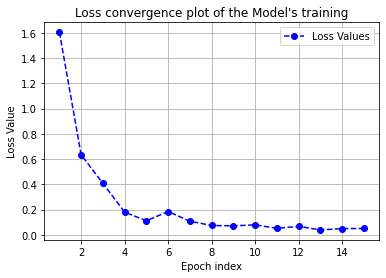


----- finished function plot_loss_convergence -----
 \ * / FINISHED train_prediction_model \ * / 

## perform on TRAIN data ##

----- entered function getSingleDimPrediction -----
Reached end of the function, printing information about the prediction vs the truth values
       M_truth    M_pred
0     1.098612  0.901886
1     0.693147  0.523726
2     0.000000  0.094068
3     0.000000 -0.123857
4     1.386294  1.088885
...        ...       ...
3808  1.098612  0.990856
3809  0.000000 -0.326534
3810  1.609438  1.356493
3811  0.000000 -0.105753
3812  0.000000 -0.166771

[3813 rows x 2 columns]

----- finished function getSingleDimPrediction -----
distance between M_truth, M_pred: 14.749445671987438
distance between M_truth, Baseline: 71.81767094115322
distance between M_pred, Baseline: 69.43429818969105

----- entered function plot_Single_Gene_PredAndTrue -----


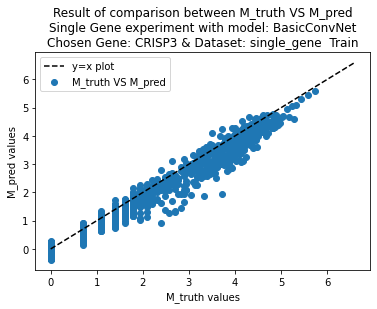

finished preparing the plots, now just need to show on screen ....


<Figure size 432x288 with 0 Axes>

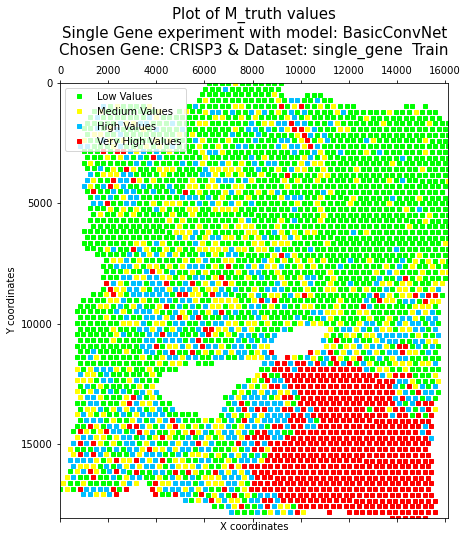

<Figure size 432x288 with 0 Axes>

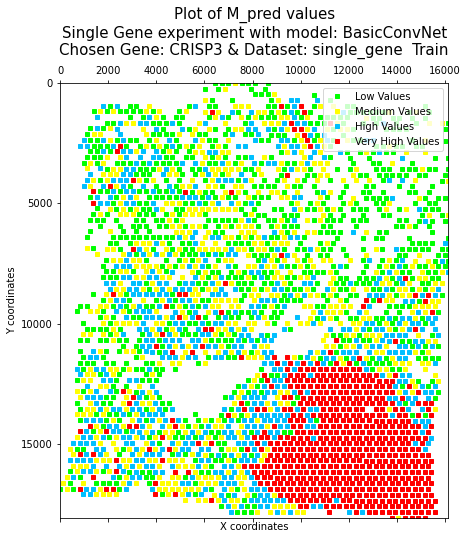


----- finished function plot_Single_Gene_PredAndTrue -----

## perform on TEST data ##

----- entered function getSingleDimPrediction -----
Reached end of the function, printing information about the prediction vs the truth values
       M_truth    M_pred
0     0.000000  0.721733
1     1.098612  0.963073
2     0.693147  0.873207
3     1.098612  0.537352
4     0.000000  0.135940
...        ...       ...
4010  1.386294  0.746538
4011  0.693147  0.341586
4012  0.000000  0.812372
4013  0.693147  1.809786
4014  0.000000  1.231647

[4015 rows x 2 columns]

----- finished function getSingleDimPrediction -----
distance between M_truth, M_pred: 73.87204042930794
distance between M_truth, Baseline: 72.60879747586873
distance between M_pred, Baseline: 29.269556494582943

----- entered function plot_Single_Gene_PredAndTrue -----


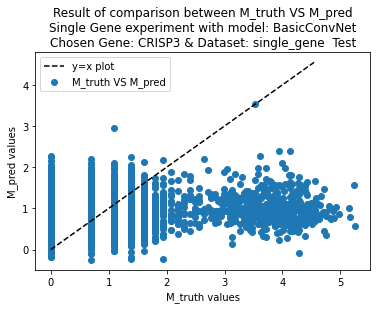

finished preparing the plots, now just need to show on screen ....


<Figure size 432x288 with 0 Axes>

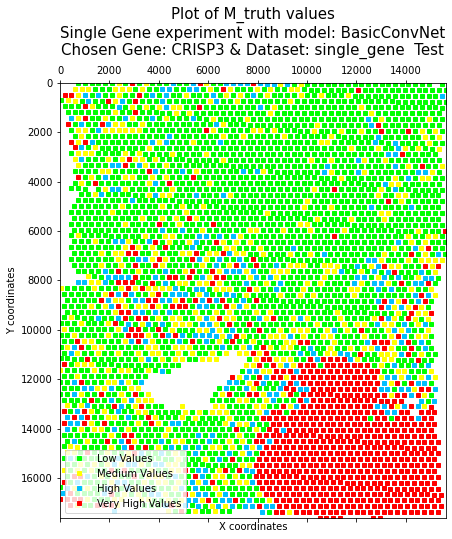

<Figure size 432x288 with 0 Axes>

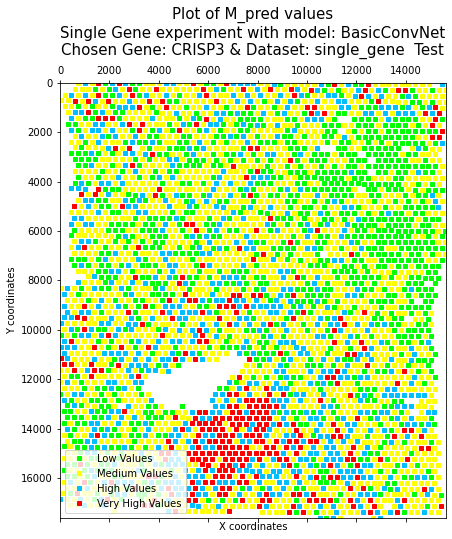


----- finished function plot_Single_Gene_PredAndTrue -----

----- finished function runExperiment -----
CPU times: user 1h 7min 45s, sys: 9min 41s, total: 1h 17min 27s
Wall time: 1h 26min 58s


<Figure size 432x288 with 0 Axes>

In [24]:
%%time

executionModule.runExperiment(ds_train=custom_DS_SingleValuePerImg_augmented, 
                                ds_test=custom_DS_SingleValuePerImg_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='BasicConvNet', 
                                dataset_name='single_gene ')


----- entered function runExperiment -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******
finished all epochs !                                         
which means, that this model is now trained.
plotting the loss convergence for the training of this model: 

----- entered function plot_loss_convergence -----


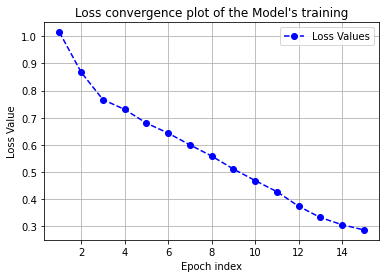


----- finished function plot_loss_convergence -----
 \ * / FINISHED train_prediction_model \ * / 

## perform on TRAIN data ##

----- entered function getSingleDimPrediction -----
Reached end of the function, printing information about the prediction vs the truth values
       M_truth    M_pred
0     1.098612  1.300293
1     0.693147  1.021848
2     0.000000  0.315109
3     0.000000  0.712074
4     1.386294  2.745102
...        ...       ...
3808  1.098612  0.962563
3809  0.000000  0.235891
3810  1.609438  1.521361
3811  0.000000  0.106909
3812  0.000000  0.106818

[3813 rows x 2 columns]

----- finished function getSingleDimPrediction -----
distance between M_truth, M_pred: 32.35017826900204
distance between M_truth, Baseline: 71.81767094115322
distance between M_pred, Baseline: 64.1290467017143

----- entered function plot_Single_Gene_PredAndTrue -----


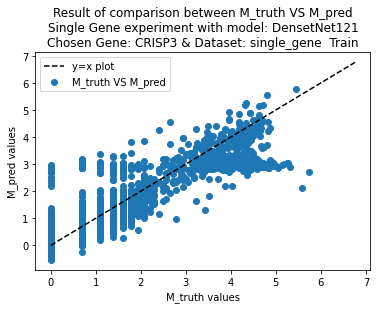

finished preparing the plots, now just need to show on screen ....


<Figure size 432x288 with 0 Axes>

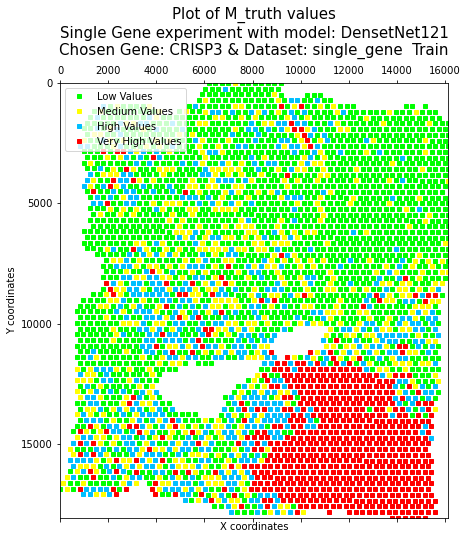

<Figure size 432x288 with 0 Axes>

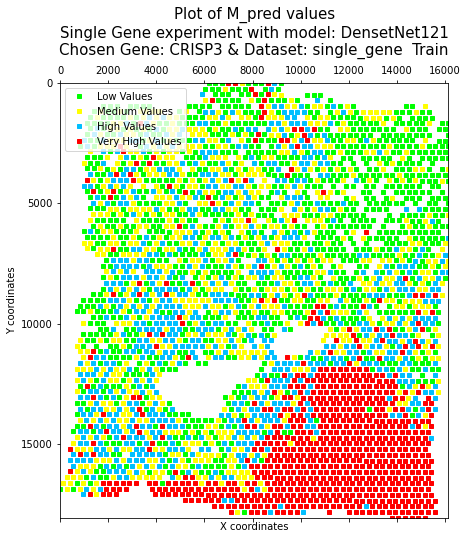


----- finished function plot_Single_Gene_PredAndTrue -----

## perform on TEST data ##

----- entered function getSingleDimPrediction -----
Reached end of the function, printing information about the prediction vs the truth values
       M_truth    M_pred
0     0.000000  2.962799
1     1.098612  0.960981
2     0.693147  3.085125
3     1.098612  0.899506
4     0.000000  0.536041
...        ...       ...
4010  1.386294  1.300947
4011  0.693147  0.577588
4012  0.000000  0.636448
4013  0.693147  3.122894
4014  0.000000  0.789463

[4015 rows x 2 columns]

----- finished function getSingleDimPrediction -----
distance between M_truth, M_pred: 79.5894789665486
distance between M_truth, Baseline: 72.60879747586873
distance between M_pred, Baseline: 48.33144407202796

----- entered function plot_Single_Gene_PredAndTrue -----


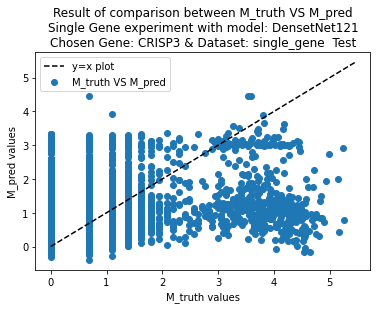

finished preparing the plots, now just need to show on screen ....


<Figure size 432x288 with 0 Axes>

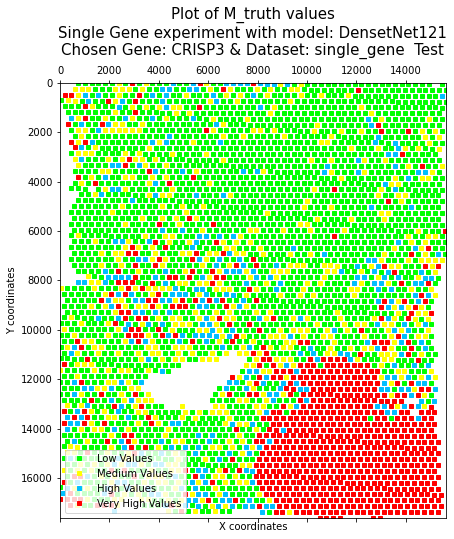

<Figure size 432x288 with 0 Axes>

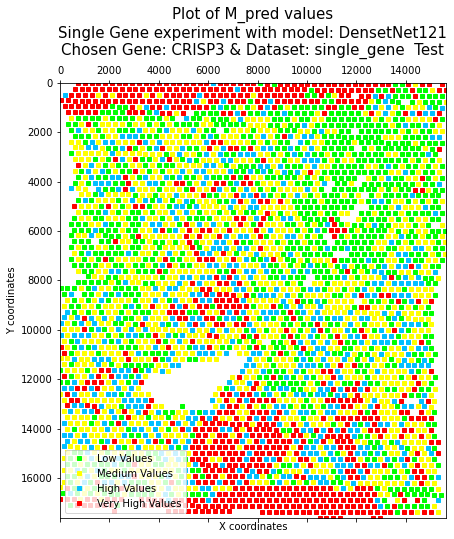


----- finished function plot_Single_Gene_PredAndTrue -----

----- finished function runExperiment -----
CPU times: user 2h 22min 37s, sys: 11min 16s, total: 2h 33min 53s
Wall time: 2h 41min 55s


<Figure size 432x288 with 0 Axes>

In [25]:
%%time

executionModule.runExperiment(ds_train=custom_DS_SingleValuePerImg_augmented, 
                                ds_test=custom_DS_SingleValuePerImg_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='DensetNet121', 
                                dataset_name='single_gene ')

## Phase 3: K genes prediction

In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_KGenesWithHighestVariance_augmented, 
                                ds_test=custom_DS_KGenesWithHighestVariance_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='BasicConvNet', 
                                dataset_name='k_genes ')


----- entered function runExperiment -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******


In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_KGenesWithHighestVariance_augmented, 
                                ds_test=custom_DS_KGenesWithHighestVariance_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='DensetNet121', 
                                dataset_name='k_genes ')

## Phase 4: All genes prediction - using dimensionality reduction techniques

### 4.1: Prediction using dimensionality reduction technique NMF

In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_LatentTensor_NMF_augmented, 
                                ds_test=custom_DS_LatentTensor_NMF_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='BasicConvNet', 
                                dataset_name='NMF ')

In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_LatentTensor_NMF_augmented, 
                                ds_test=custom_DS_LatentTensor_NMF_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='DensetNet121', 
                                dataset_name='NMF ')

### 4.2: Prediction using dimensionality reduction technique AE

In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_LatentTensor_AE_augmented, 
                                ds_test=custom_DS_LatentTensor_AE_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='BasicConvNet', 
                                dataset_name='AE ')

In [ ]:
%%time

executionModule.runExperiment(ds_train=custom_DS_LatentTensor_AE_augmented, 
                                ds_test=custom_DS_LatentTensor_AE_test,
                                hyperparams=hyperparameters, 
                                device=device, 
                                model_name='DensetNet121', 
                                dataset_name='AE ')

<div class="alert alert-block alert-danger">
<b>Note:</b> below this - everything is a testing block
</div>